# Fine tuning Large Langua Model(LLM) - DistilBERT


## Libraries


In [1]:
import transformers
from transformers import AutoTokenizer, set_seed
from datasets import Dataset, DatasetDict, ClassLabel
import pandas as pd
import numpy as np
import evaluate
import torch
from transformers import pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

2024-10-20 16:03:11.532943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 16:03:11.639391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 16:03:11.673191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 16:03:11.898601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 16:03:13.938755: W tensorflow/compiler/tf2

In [2]:
# Set a random seed for reproducibility
seed_value = 42
set_seed(seed_value)

## Dataset

Se cargan los datasets de `training`, `validation` y `test`. Se utiliza cada uno para:

- `training` = Realizar el fine tunning del modelo.
- `validation` = validar el proceso de fine tunning.
- `test` = testear el modelo con nuevos datos.


In [3]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv").rename(
    columns={"emotion": "label"}
)
df_val = pd.read_csv("../data/data_to_model/val_data.csv").rename(
    columns={"emotion": "label"}
)
df_test = pd.read_csv("../data/data_to_model/test_data.csv").rename(
    columns={"emotion": "label"}
)

### Consolidating training, validation y test:


In [4]:
# Convert the pandas DataFrame into a Dataset
df_dict_train = Dataset.from_pandas(df_train)
df_dict_train = df_dict_train.class_encode_column("label")

df_dict_val = Dataset.from_pandas(df_val)
df_dict_val = df_dict_val.class_encode_column("label")

df_dict_test = Dataset.from_pandas(df_test)
df_dict_test = df_dict_test.class_encode_column("label")


# Crear el DatasetDict con train, validation y test
emotions = DatasetDict(
    {
        "train": df_dict_train,
        "validation": df_dict_val,
        "test": df_dict_test,
    }
)


# Verificar el resultado
emotions

Casting to class labels:   0%|          | 0/6027 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/753 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/754 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6027
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 753
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 754
    })
})

In [5]:
emotions.set_format("pandas")
df = emotions["train"][:]
df.head()

,text,label
0,when the week for exams came i got afraid as t...,2
1,i was sleeping when i heard the neighbours scr...,2
2,there was a time when my room looked terribly ...,6
3,when my friend told me that he would come and ...,4
4,"when i saw the film ""johnny got his gun"" which...",5


In [6]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)


df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,when the week for exams came i got afraid as t...,2,fear
1,i was sleeping when i heard the neighbours scr...,2,fear
2,there was a time when my room looked terribly ...,6,shame
3,when my friend told me that he would come and ...,4,joy
4,"when i saw the film ""johnny got his gun"" which...",5,sadness


In [7]:
emotions.reset_format()

## Tokenize Text


In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased", clean_up_tokenization_spaces=True
)

In [9]:
print("The vocabulary size is:", tokenizer.vocab_size)
print("Maximum context size:", tokenizer.model_max_length)
print(
    "Name of the fields, model need in the forward pass:", tokenizer.model_input_names
)

The vocabulary size is: 30522
Maximum context size: 512
Name of the fields, model need in the forward pass: ['input_ids', 'attention_mask']


In [10]:
# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [11]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 2043, 1996, 2733, 2005, 13869, 2234, 1045, 2288, 4452, 2004, 2000, 2129, 1045, 2052, 11147, 1996, 3980, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2001, 5777, 2043, 1045, 2657, 1996, 14754, 7491, 1010, 1045, 21392, 5669, 2083, 1996, 3332, 1998, 2387, 1037, 12383, 2667, 2000, 4607, 2026, 20065, 1005, 1055, 2160, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [12]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [13]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

## Analyzing encoded text


In [14]:
import torch
import torch.nn as nn

In [15]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [16]:
def extract_hidden_states(batch):
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [17]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
print(type(emotions_encoded["train"]["input_ids"]))

<class 'torch.Tensor'>


In [18]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [19]:
emotions_hidden["train"].column_names


['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [20]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden state"])
X_valid = np.array(emotions_hidden["validation"]["hidden state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

(6027, 768) (753, 768)


In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

(6027, 2)

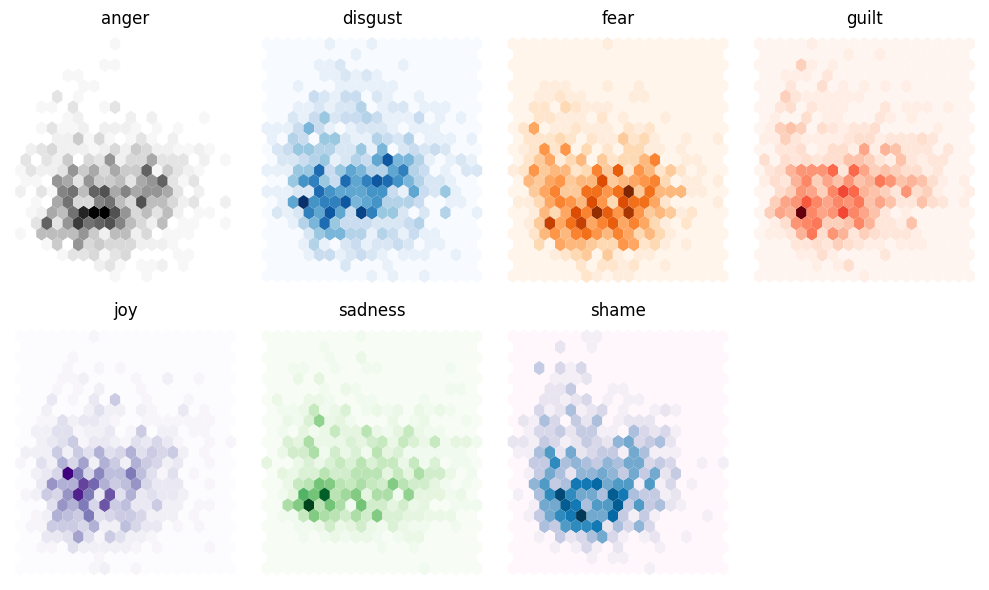

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(10, 6))
ax = ax.flatten()

# Ensure we have enough colormaps for all labels
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", "PuBu"]
labels = emotions["train"].features["label"].names

# Plot for each label
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].hexbin(
        x_2d_sub[:, 0], x_2d_sub[:, 1], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    ax[i].set_title(label)
    ax[i].set_axis_off()

# Hide the extra subplot (8th one) if it exists
if len(ax) > len(labels):
    ax[-1].set_visible(False)

plt.tight_layout()
plt.show()

### Base Models with tokenized Data


In [23]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.601593625498008

In [24]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")  # Predict the most frequent
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.14475431606905712

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

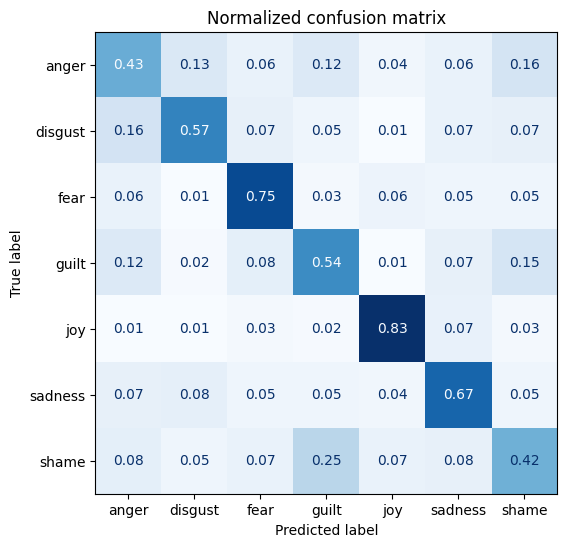

In [26]:
y_pred = lr_clf.predict(X_valid)
plot_confusion_matrix(y_pred, y_valid, labels)

## Fine-tuning


In [27]:
from transformers import AutoModelForSequenceClassification

num_labels = 7
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [29]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-isear-2"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=20,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none",
)

/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [45]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6027
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 753
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 754
    })
})

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.655500,1.272226,0.614874,0.614586
2,1.093700,0.992761,0.662683,0.660098
3,0.830300,0.958551,0.665339,0.668271
4,0.659800,0.960307,0.673307,0.676635
5,0.517100,0.963980,0.678619,0.678603
6,0.408100,1.004031,0.674635,0.675052
7,0.311500,1.074570,0.671979,0.675035
8,0.232700,1.146738,0.673307,0.676014
9,0.169700,1.189288,0.673307,0.677527
10,0.135300,1.241445,0.681275,0.682155


TrainOutput(global_step=1900, training_loss=0.3216556507035306, metrics={'train_runtime': 751.0238, 'train_samples_per_second': 160.501, 'train_steps_per_second': 2.53, 'total_flos': 2276836356294360.0, 'train_loss': 0.3216556507035306, 'epoch': 20.0})

In [31]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [32]:
preds_output.metrics

{'test_loss': 1.586924433708191,
 'test_accuracy': 0.6786188579017264,
 'test_f1': 0.6807963858041709,
 'test_runtime': 1.3204,
 'test_samples_per_second': 570.287,
 'test_steps_per_second': 9.088}

In [33]:
y_preds = np.argmax(preds_output.predictions, axis=1)

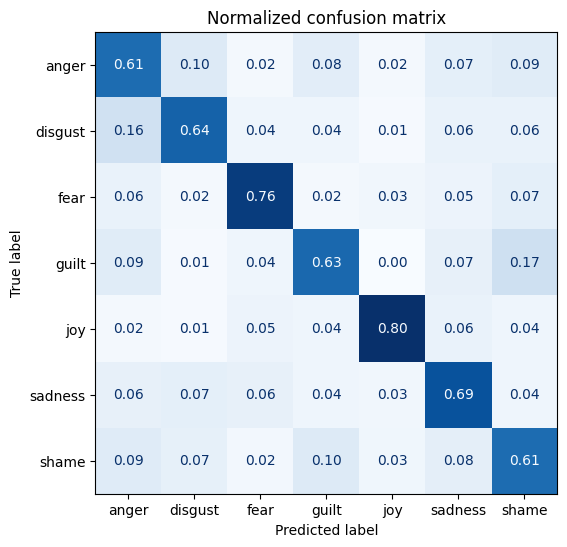

In [34]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [35]:
trainer.save_model("models/distilbert-base-uncased-finetuned-isear-2")

## Predictions on test dataset


In [36]:
emotions_hidden["test"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [37]:
# Evaluar el modelo en el conjunto de prueba
test_results = trainer.evaluate(eval_dataset=emotions_hidden["test"])

# Imprimir los resultados de las métricas en el conjunto de prueba
test_results

{'eval_loss': 1.43794584274292,
 'eval_accuracy': 0.6949602122015915,
 'eval_f1': 0.6976576650826974,
 'eval_runtime': 1.6154,
 'eval_samples_per_second': 466.763,
 'eval_steps_per_second': 7.429,
 'epoch': 20.0}

In [38]:
preds_output = trainer.predict(emotions_encoded["test"])

In [39]:
preds_output = trainer.predict(emotions_encoded["test"])

In [40]:
y_pred_test = np.argmax(preds_output.predictions, axis=1)
len(y_pred_test)

754

In [41]:
preds_output.metrics

{'test_loss': 1.43794584274292,
 'test_accuracy': 0.6949602122015915,
 'test_f1': 0.6976576650826974,
 'test_runtime': 1.3512,
 'test_samples_per_second': 558.017,
 'test_steps_per_second': 8.881}

In [42]:
y_test = np.array(emotions_hidden["test"]["label"])
len(y_test)

754

Classification Report:
              precision    recall  f1-score   support

       anger       0.63      0.64      0.64       109
     sadness       0.70      0.69      0.69       107
       shame       0.86      0.80      0.83       109
       guilt       0.59      0.58      0.58       106
     disgust       0.89      0.85      0.87       109
        fear       0.71      0.69      0.70       108
         joy       0.52      0.60      0.56       106

    accuracy                           0.69       754
   macro avg       0.70      0.69      0.70       754
weighted avg       0.70      0.69      0.70       754



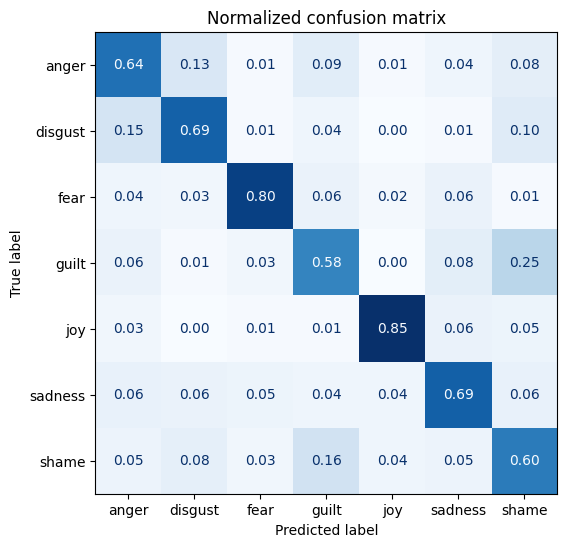

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,distilbert-base-uncased-2,Fine Tuning,0.69496,0.700638,0.694122,0.696661


In [43]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    y_test,
    y_pred_test,
    output_dict=True,
    target_names=df_test["label"].unique(),
)
print(
    classification_report(
        y_test,
        y_pred_test,
        target_names=df_test["label"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": "distilbert-base-uncased-2",
        "Method": "Fine Tuning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

plot_confusion_matrix(y_pred_test, y_test, labels)

results_df

In [44]:
results_df.to_excel("../data/model_results/llm_distilbert-20.xlsx", index=False)